# Build a neural network from scratch with Numpy

In this project, we build a neural network from scratch with numpy and then use it to predict daily bike rental ridership.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Dummy-categorical-variables" data-toc-modified-id="Dummy-categorical-variables-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dummy categorical variables</a></span></li><li><span><a href="#Scale-target-variables" data-toc-modified-id="Scale-target-variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scale target variables</a></span></li><li><span><a href="#Split-data-into-training,-testing,-and-validation-sets" data-toc-modified-id="Split-data-into-training,-testing,-and-validation-sets-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split data into training, testing, and validation sets</a></span></li></ul></li><li><span><a href="#Build-the-actual-network" data-toc-modified-id="Build-the-actual-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the actual network</a></span><ul class="toc-item"><li><span><a href="#Work-through-an-illustrative-dummy-Network" data-toc-modified-id="Work-through-an-illustrative-dummy-Network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Work through an illustrative dummy Network</a></span></li><li><span><a href="#Build-the-actual-network" data-toc-modified-id="Build-the-actual-network-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Build the actual network</a></span></li><li><span><a href="#Run-unit-tests" data-toc-modified-id="Run-unit-tests-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Run unit tests</a></span></li></ul></li><li><span><a href="#Training-the-network" data-toc-modified-id="Training-the-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training the network</a></span><ul class="toc-item"><li><span><a href="#Choose-the-number-of-iterations" data-toc-modified-id="Choose-the-number-of-iterations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Choose the number of iterations</a></span></li><li><span><a href="#Choose-the-learning-rate" data-toc-modified-id="Choose-the-learning-rate-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Choose the learning rate</a></span></li><li><span><a href="#Choose-the-number-of-hidden-nodes" data-toc-modified-id="Choose-the-number-of-hidden-nodes-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Choose the number of hidden nodes</a></span></li></ul></li><li><span><a href="#Visualize-the-predictions" data-toc-modified-id="Visualize-the-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize the predictions</a></span></li></ul></div>

## Import libraries, load data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
print(rides.shape)
display(rides.head())

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Prepare the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. 

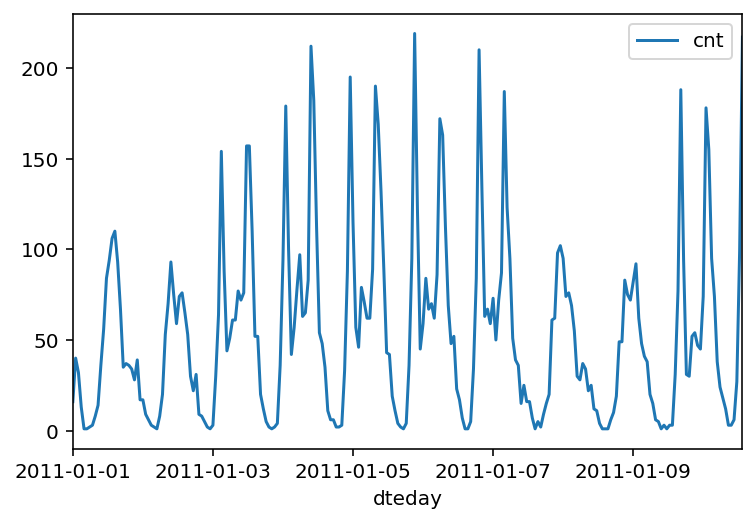

In [4]:
rides[:24*10].plot(x='dteday', y='cnt');

**Observations:** The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. (Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. We'll be trying to capture all this with our model.)

### Dummy categorical variables

In [5]:
dummy_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
rides_dummy = pd.get_dummies(rides, columns=dummy_cols, prefix=dummy_cols, drop_first=False)
# Drop some additional fields we don't use for our model
data = rides_dummy.drop(['instant', 'dteday', 'atemp', 'workingday'], axis=1)

### Scale target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
data.head(2)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [8]:
# Check results
display(scaled_features)
display(data.head(2))

{'casual': [35.67621842453536, 49.305030387053186],
 'registered': [153.78686920996606, 151.35728591258317],
 'cnt': [189.46308763450142, 181.38759909186527],
 'temp': [0.4969871684216586, 0.19255612124972407],
 'hum': [0.6272288394038822, 0.1929298340629125],
 'windspeed': [0.1900976063064631, 0.12234022857279413]}

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1


### Split data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [9]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll further split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [11]:
# Check results
print(features.shape)
print(targets.shape)

(16875, 56)
(16875, 3)


## Build the actual network


<img src="pics/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

### Work through an illustrative dummy Network

In [12]:
"""Illustration - Dummy Example"""

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])


# Check results
print("Input Shapes\n")
print("inputs", inputs.shape)
print("weights to hidden", test_w_i_h.shape)
print("weights to output", test_w_h_o.shape)
print("Targets", targets.shape)


activation_function = lambda x : 1 / (1 + np.exp(-x))
learn_rate = 0.5

print("\n\nForward Pass\n")
hidden_inputs = np.dot(inputs, test_w_i_h)
print(f"hidden inputs ({hidden_inputs.shape}) = inputs ({inputs.shape}) * test_w_i_h ({test_w_i_h.shape})")
hidden_outputs = activation_function(hidden_inputs)
print("hidden outputs", hidden_outputs.round(3))
final_inputs = np.dot(hidden_outputs, test_w_h_o)
print(f"\nfinal inputs ({final_inputs.shape}) = hidden_outputs ({hidden_outputs.shape}) * test_w_h_o ({test_w_h_o.shape})")
final_outputs = final_inputs # no activation function here
print("final outputs", final_outputs.round(3))

print("\n\nBackward Pass\n")
error = targets - final_outputs
# Backpropagated error terms
output_error_term = error  # No activation function in the output layer!
print("Output_error_term", output_error_term)
# Calculate the hidden layer's contribution to the error
hidden_error = np.dot(output_error_term, test_w_h_o.T)
print(f"hidden error ({hidden_error.shape}) = output_error_term ({output_error_term.shape}) * test_w_h_o.T ({test_w_h_o.T.shape})")
# Backpropagated error terms
hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
print("hidden_error_term", hidden_error_term)
# Weight step (input to hidden)
delta_w_i_h = np.dot(inputs.T, hidden_error_term)
print("\ndelta_w_h_i", delta_w_i_h)
# Weight step (hidden to output)
delta_w_h_o = output_error_term * hidden_outputs.T
print("delta_w_h_o", delta_w_h_o) 

# Weight update
test_w_i_h += delta_w_i_h/inputs.shape[0] * learn_rate
test_w_h_o += delta_w_h_o/inputs.shape[0] * learn_rate
print("\n\nupdated delta_w_i_h", delta_w_i_h)
print("\nupdated delta_w_h_o", delta_w_h_o)

Input Shapes

inputs (1, 3)
weights to hidden (3, 2)
weights to output (2, 1)
Targets (1, 1)


Forward Pass

hidden inputs ((1, 2)) = inputs ((1, 3)) * test_w_i_h ((3, 2))
hidden outputs [[0.485 0.455]]

final inputs ((1, 1)) = hidden_outputs ((1, 2)) * test_w_h_o ((2, 1))
final outputs [[0.1]]


Backward Pass

Output_error_term [[0.30001076]]
hidden error ((1, 2)) = output_error_term ((1, 1)) * test_w_h_o.T ((1, 2))
hidden_error_term [[ 0.02248057 -0.00743984]]

delta_w_h_i [[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]
delta_w_h_o [[0.14550657]
 [0.13654123]]


updated delta_w_i_h [[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]

updated delta_w_h_o [[0.14550657]
 [0.13654123]]


### Build the actual network

In [18]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5,
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        # Set self.activation_function to your implemented sigmoid function
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))

    def train(self, features, targets):
        ''' Train the network on batch of features and targets.

            Arguments
            ---------

            features: 2D array, each row is a record, each column a feature
            targets: 1D array of target values

        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)

        for X, y in zip(features, targets):
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(
                final_outputs, hidden_outputs, X, y,
                delta_weights_i_h, delta_weights_h_o)

        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

    def forward_pass_train(self, X):
        ''' Implement forward pass here

            Arguments
            ---------
            X: features batch

        '''

        # Signals into and from hidden layer
        hidden_inputs = np.dot(X, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signals into and from output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs  # this is a regression function, so no activation function in the output layer!

        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y,
                        delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation

            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
        '''

        # Output error
        error = y - final_outputs

        # Backpropagated error terms
        output_error_term = error  # this is a regression function, so no activation function in the output layer!

        # Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)

        # Backpropagated error terms
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)


        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]

        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step

            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''

        # Update with gradient descent step
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records

    def run(self, features):
        ''' Run a forward pass through the network with input features

            Arguments
            ---------
            features: 1D array of feature values
        '''

        hidden_inputs = np.dot(features,  self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs

        return final_outputs

In [14]:
# Initialize an instance with 3 input nodes, 2 hidden nodes, 1 ouput node
network = NeuralNetwork(3, 2, 1, 0.5)

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

network.weights_input_to_hidden = test_w_i_h.copy()
network.weights_hidden_to_output = test_w_h_o.copy()

In [15]:
# Train the network
network.train(inputs, targets)

In [23]:
# Define the loss function
def MSE(y, Y):
    return np.mean((y-Y)**2)

### Run unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [21]:
import unittest

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'data/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.009s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the **hyperparameters** for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

We are using a method known as **Stochastic Gradient Descent (SGD)** to train the network. For each training pass, we use a random sample of the data instead of using the whole data set. This requires many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. 

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations we use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations. We want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose. You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [29]:
import sys

# Set the hyperparameters
iterations = 2000
learning_rate = 0.9
hidden_nodes = 14
output_nodes = 1

# Perform batchwise training
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.085 ... Validation loss: 0.165

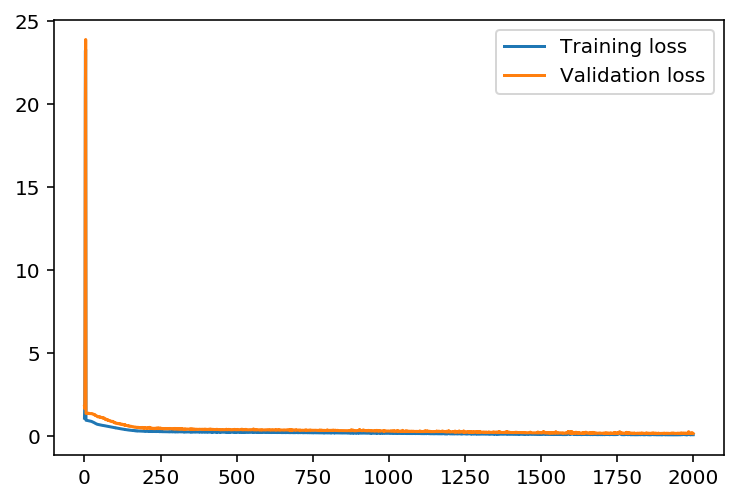

In [30]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Visualize the predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

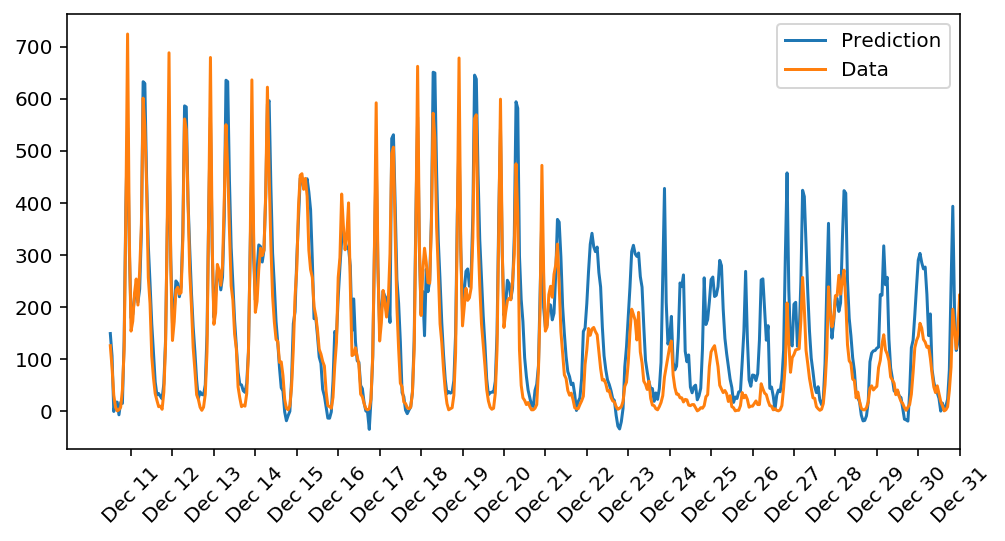

In [31]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

---